In [1]:
import datetime
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from data_cleaning.ml_utils import available_indices, extract_data, get_sliding_data
from data_cleaning.utils import *
from data_cleaning.predict import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [3]:
# linear regression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


In [4]:
# Load data
DATA_FOLDER = os.path.join("data_cleaning", "data")
def path(filename):
    return os.path.join(DATA_FOLDER, filename)

orig_full_data = np.load(path("full_np_data.pickle.npy"))
inter_full_data = np.load(path("linear_inter.pickle.npy"))
spline_full_data = np.load(path("spline_inter.pickle.npy"))
orig_dates = np.load(path("dates.pickle.npy"))
names = pickle.load(open(path("filenames.pickle"), "rb"))
dates = np.load(path("dates.pickle.npy"))

In [5]:
# Select date for predictions
start_date = datetime.date(day=3, month=1, year=2013)
end_date = datetime.date(day=31, month=12, year=2015)

In [6]:
# Get data and valid measurements indices
inds, data, config = extract_data(orig_dates, start_date, end_date, inter_full_data)
inds2, data_spline, config2 = extract_data(orig_dates, start_date, end_date, spline_full_data)
start = config["start"]
end = config["end"]
assert inds == inds2
print("Available indices: ", inds)
print(np.array(names)[inds])
print(config)

Available indices:  [4, 9, 24, 33, 38, 42, 45, 46, 47, 50, 51, 52]
['data/raw/85004.csv' 'data/raw/85012.csv' 'data/raw/85030.csv'
 'data/raw/85040.csv' 'data/raw/85050.csv' 'data/raw/85054.csv'
 'data/raw/85063.csv' 'data/raw/85064.csv' 'data/raw/85065.csv'
 'data/raw/85073.csv' 'data/raw/85075.csv' 'data/raw/85076.csv']
{'start': 23013, 'end': 24105}


24106


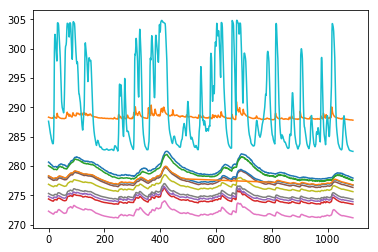

In [7]:
# Plot (linearly intrpolated) data acquired in that date range
print(len(inter_full_data[inds[2]]))
for part in data:
    plt.plot(part)


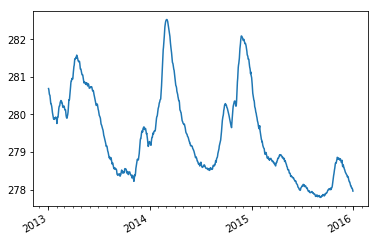

In [8]:
fig, ax = plt.subplots()
ax.plot(dates[start:end], data[0])

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(dates[0])
datemax = np.datetime64(dates[-1], 'Y')
#ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 319


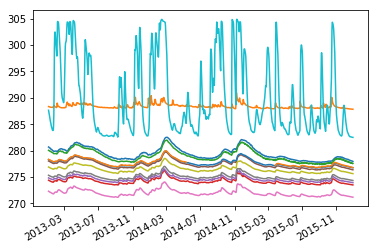

In [9]:
def get_data_plotter(datess):
    fig, ax = plt.subplots()
    #add_dates(ax, datess)
    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    def plotter(dat):
        ax.plot(datess, dat)
        
    return fig, ax, plotter

def add_dates(ax, datess, add_y=False):
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(datess[0])
    datemax = np.datetime64(datess[-1], 'Y')
    #ax.set_xlim(datemin, datemax)
    if add_y:
        ax.set_ylim(270, 310)
    # format the coords message box
    def price(x):
        return '$%1.2f' % x
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

figg, axx, pl = get_data_plotter(dates[start:end])
for i, part in enumerate(orig_full_data[inds2, start:end]):
    print(i, sum(np.isnan(part)))
    pl(part)

plt.savefig("report2/all.pdf")

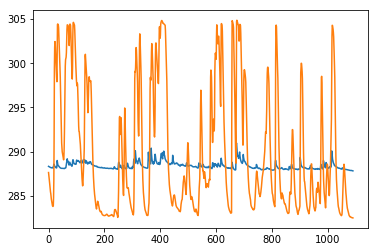

In [10]:
interesting = [1, 9]
faulty = 11
#plt.plot(orig_full_data[inds2[11],start:end])
individual = interesting + [faulty]
for j in interesting:
    plt.plot(orig_full_data[inds2[j],start:end])


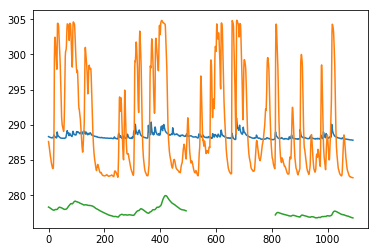

In [11]:
for j in individual:
    plt.plot(orig_full_data[inds2[j],start:end])

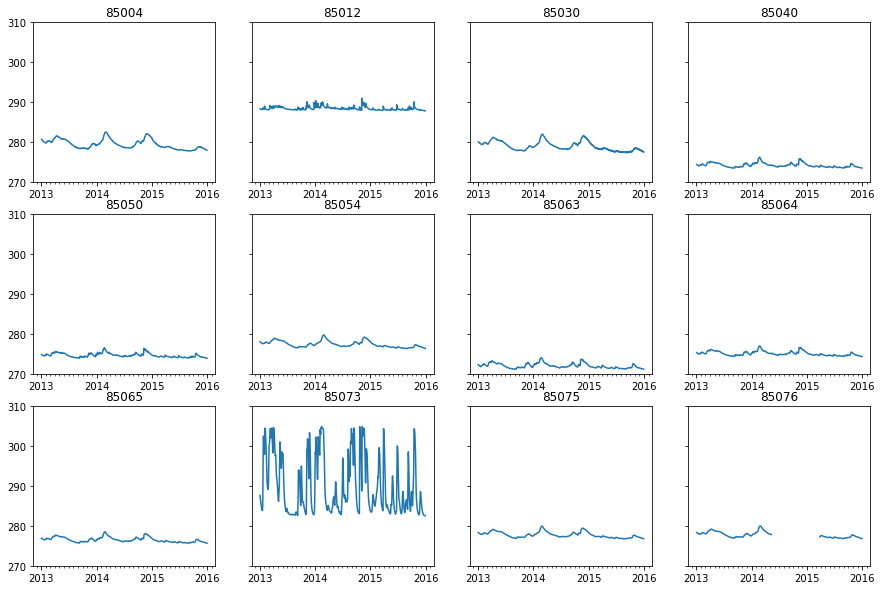

In [12]:
col = 4
N = len(inds2)
scale = 4
figg, ax = plt.subplots(N//col,col, sharey="row", figsize = (15, 10))
for i, a in enumerate(ax):
    for j,b in enumerate(a):
        n = i*col + j
        index = inds2[n]
        name = names[index].split("/")[-1].split(".")[0]
        b.set_title(name)
        add_dates(b, dates[start:end], add_y=1)
        b.plot(dates[start:end], orig_full_data[index,start:end])
#plt.suptitle("Sample measurements")
plt.savefig("report2/multifig_measurements.pdf")

In [13]:
best_predictions = [None for j in range(len(inds))]
correct_inidices = inds[:]
correct_inidices.pop(faulty)
# Predict normal measurements
for j in range(len(inds)):
    if j in individual:
            continue
    preds = predict_all(correct_inidices, orig_full_data[correct_inidices, start:end], j, linear_model.LinearRegression, seed=18 + 5 + 2018, verbose=1)
    best_predictions[j] = preds[0]

11 1092
11 1092
11 1092
11 1092
11 1092
11 1092
11 1092
11 1092
11 1092


In [14]:
for k in individual:
    assert best_predictions[k] is None
for j, pp in enumerate(best_predictions):
    print(j, pp)

0 (0.99627412355081035, [1, 2, 3, 4, 5, 7, 8, 9, 10], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.072873540596040329})
1 None
2 (0.99615464509008345, [0, 1, 3, 4, 5, 6, 8, 9, 10], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.07171356107076747})
3 (0.99677138536352328, [0, 1, 2, 4, 5, 6, 7, 8, 9], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.029624997048320136})
4 (0.99869874532384617, [0, 1, 5, 6, 7, 8, 9], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.017821739721912064})
5 (0.9996209461163037, [0, 1, 2, 3, 4, 6, 7, 8, 10], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.015300954111538983})
6 (0.99027503293692798, [1, 2, 3, 4, 5, 7, 9, 10], LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), {'rmse': 0.059120751157083075})
7 (0.99965083609186367

In [15]:
# Missing data
# Predict missing
objective = 11
strange = orig_full_data[inds[objective]][start:end]
print(start, end)
fst = find_fst_nan(strange)
snd = find_last_nan(strange)
#plt.plot(strange)
print(fst, snd)
helper = Holder(fst, snd)
clip = helper.clip

23013 24105
494 813


In [16]:
# Make best prediction for faulty measurements

clipped_data = np.array(data)
clipped_data = np.array([clip(j) for j in clipped_data])
preds = predict_all(inds, clipped_data, objective, linear_model.LinearRegression, seed=18 + 5 + 2018, verbose=True)
best_strange = preds[0]
best_predictions[objective] = best_strange

12 773


In [17]:
#model = best_strange[2]
fit_ind = 11
r2, fit_ind, model = best_strange
figg, (f,s) = plt.subplots(1,2, sharey="row", figsize = (16, 4))
add_dates(f, dates[start:end])
add_dates(s, dates[start:end])
f.plot(dates[start:end], strange)
f.set_title("Original values (with missing values)")
s.plot(dates[start:end], strange)
s.plot(dates[start:end], model.predict(np.array(data)[fit_ind].T))
#s.plot(dates[start+fst:start+snd], preddd[fst:snd])

s.set_title("Original values (blue) overlapped with predicted (orange)")
plt.savefig("report2/missing_prediction-only.pdf")

ValueError: too many values to unpack (expected 3)

In [18]:
# Predict two seemingly different samples
# (Heavy)
machinery = [GradientBoostingRegressor, SVR, RandomForestRegressor, DecisionTreeRegressor, 
             linear_model.LinearRegression]

for ind in interesting:
    print("Index: ", ind)
    best_predictions[ind] = None # Just to be sure that we update things
    for mac in machinery:    
        name = str(mac).split(".")[-1].split("'")[0]
        print(name)
        preds = predict_all(correct_inidices, orig_full_data[correct_inidices, start:end], ind, 
                            mac, seed=18 + 5 + 2018, verbose=True)
        if best_predictions[ind] is None or best_predictions[ind][0] < preds[0][0]:
            best_predictions[ind] = preds[0]
        print(preds[0])


Index:  1
GradientBoostingRegressor
11 1092


KeyboardInterrupt: 

In [19]:
ftt = []
inds_good = inds2[:]
inds_good.pop(11)
print(orig_full_data.shape)
# Gradient boositing regression se obnasa neprimerno bolje
for pump in interesting:
    print(pump)
    preds = predict_all(inds_good, np.array(orig_full_data)[inds_good, start:end], pump, GradientBoostingRegressor, seed=18 + 5 + 2018)
    best = preds[0]
    print(best[0], best[1])
    ftt.append(best)


(53, 24106)
1
11 1092


KeyboardInterrupt: 

In [ ]:
ftt = []
inds_good = inds2[:]
inds_good.pop(11)
print(orig_full_data.shape)
# Gradient boositing regression se obnasa neprimerno bolje
for pump in interesting:
    print(pump)
    preds = predict_all(inds_good, np.array(orig_full_data)[inds_good, start:end], pump, GradientBoostingRegressor, seed=18 + 5 + 2018)
    best = preds[0]
    print(best[0], best[1])
    ftt.append(best)


In [ ]:
inddd = 0
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

In [ ]:
inddd = 1
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

In [ ]:
inddd = 0
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

In [ ]:
inddd = 1
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

In [ ]:
# Final full plots
col = 4
N = len(inds2)
scale = 4
figg, ax = plt.subplots(N//col,col, sharey="row", figsize = (15, 10))
for i, a in enumerate(ax):
    for j,b in enumerate(a):
        n = i*col + j
        index = inds2[n]
        name = names[index].split("/")[-1].split(".")[0]
        b.set_title(name)
        add_dates(b, dates[start:end], add_y=1)
        b.plot(dates[start:end], orig_full_data[index,start:end])
        if best_predictions[n]:
            r2, predictors, pred_model = best_predictions[n]
            b.plot(dates[start:end], pred_model.predict(np.array(data)[predictors].T))
#plt.suptitle("Sample measurements")
plt.savefig("report2/multifig_measurements-predictions.pdf")

In [ ]:
# Final full plots
col = 4
N = len(inds2)
scale = 4
figg, ax = plt.subplots(N//col,col, sharey="row", figsize = (15, 10))
for i, a in enumerate(ax):
    for j,b in enumerate(a):
        n = i*col + j
        index = inds2[n]
        name = names[index].split("/")[-1].split(".")[0]
        b.set_title(name)
        add_dates(b, dates[start:end], add_y=1)
        b.plot(dates[start:end], orig_full_data[index,start:end])
        if best_predictions[n]:
            r2, predictors, pred_model, *info = best_predictions[n]
            print(str(pred_model).split("(")[0])
            b.plot(dates[start:end], pred_model.predict(np.array(data)[predictors].T))
            b.text(734828, 275, f"$r^2={r2:.4f}$")
            if len(info):
                b.text(734828, 280, f"rmse={info[0]['rmse']:.4f}")
#plt.suptitle("Sample measurements")
plt.savefig("report2/multifig_measurements-predictions2-V.pdf")

In [20]:
# General analysis
correlated = [j for j in range(len(inds)) if j not in interesting]
r2_corr = list(best_predictions[j][0] for j in correlated)
rmse_corr = list(best_predictions[j][-1].get("rmse", np.nan) for j in correlated)
print("mean r2:\t", np.mean(r2_corr))
print("sd r2:\t", np.std(r2_corr))

print("mean rmse:\t", np.mean(rmse_corr))
print("sd rmse:\t", np.std(rmse_corr))


for j in interesting:
    print(best_predictions[j])


mean r2:	 0.997621770422
sd r2:	 0.00282237227017
mean rmse:	 0.0318476163735
sd rmse:	 0.0244045242241
None
None


In [21]:
print(np.correlate(data[interesting[0]], data[interesting[1]]))
print(np.corrcoef(data[interesting[0]], data[interesting[1]]))

[ 91398159.19940001]
[[ 1.          0.57641362]
 [ 0.57641362  1.        ]]


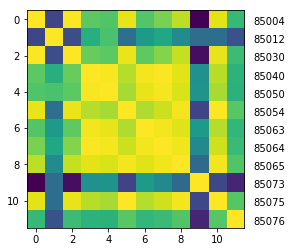

In [22]:
corr = np.corrcoef(data, data)[:len(data), :len(data)]
ax = fig.add_axes([0,0,1,1])
ax.set_axis_off()
plt.imshow(corr)
for j in range(len(data)):
    plt.text(12, j+0.3, np.array(names)[inds][j].split("/")[-1].split(".")[0])
plt.savefig("report2/corrcoef.pdf")

In [23]:
corr

array([[ 1.        ,  0.47803908,  0.99676948,  0.83436684,  0.81987028,
         0.97615278,  0.82366787,  0.86584337,  0.93391215,  0.33902714,
         0.9730481 ,  0.7808286 ],
       [ 0.47803908,  1.        ,  0.49418756,  0.75311109,  0.80951785,
         0.58180794,  0.70025074,  0.73176947,  0.65838997,  0.57641362,
         0.57880956,  0.50461992],
       [ 0.99676948,  0.49418756,  1.        ,  0.84687082,  0.83354074,
         0.98070778,  0.83644724,  0.87798528,  0.94193508,  0.36376329,
         0.97811185,  0.79302012],
       [ 0.83436684,  0.75311109,  0.84687082,  1.        ,  0.99344474,
         0.92605109,  0.9889261 ,  0.99629611,  0.97217913,  0.67377294,
         0.92950862,  0.76692761],
       [ 0.81987028,  0.80951785,  0.83354074,  0.99344474,  1.        ,
         0.91255185,  0.97749791,  0.99100918,  0.96183651,  0.68107053,
         0.91478225,  0.76281049],
       [ 0.97615278,  0.58180794,  0.98070778,  0.92605109,  0.91255185,
         1.        ,  

In [186]:
print(np.array(data).shape)

(12, 1092)


In [187]:
a = np.zeros(4)
a[2] = "2"
print(a)

[0. 0. 2. 0.]


In [208]:
def get_name_id(i):
    return np.array(names)[inds][i].split("/")[-1].split(".")[0][-2:]
preds_s = [None for _ in range(len(best_predictions))]
for i, (_, predictors, model, *_) in enumerate(best_predictions):
    print(np.array(names)[inds][i].split("/")[-1].split(".")[0][-2:], list(map(get_name_id, predictors)))
    if i not in individual:
        ind = predictors.index(1)
        print(model.coef_[ind])
        preds_s[i] = set(predictors)

04 ['12', '30', '40', '50', '54', '64', '65', '73', '75']
-0.13565245997254752
12 ['04', '50', '54', '63', '64', '65', '73', '75']
30 ['04', '12', '40', '50', '54', '63', '65', '73', '75']
-0.049439371191269114
40 ['04', '12', '30', '50', '54', '63', '64', '65', '73']
-0.022677457212326984
50 ['04', '12', '54', '63', '64', '65', '73']
0.17169046895343626
54 ['04', '12', '30', '40', '50', '63', '64', '65', '75']
0.025137763938535073
63 ['12', '30', '40', '50', '54', '64', '73', '75']
-0.034028116008803955
64 ['04', '12', '40', '50', '54', '65', '75']
-0.05289320079563372
65 ['04', '12', '30', '40', '50', '54', '63', '64']
0.007921252205573659
73 ['04', '30', '50', '54', '63']
75 ['04', '12', '30', '40', '50', '54', '63', '64']
-0.016877623078221347
76 ['12', '30', '40', '50', '54', '63', '64', '65', '73', '75']


In [209]:
inte = preds_s[0]
for k in range(1,len(preds_s)):
    if preds_s[k]:
        inte = inte & preds_s[k]
print(inte)
uni = preds_s[0]
for k in range(1,len(preds_s)):
    if preds_s[k]:
        uni = uni | preds_s[k]
print(uni)

{1}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [213]:
print(best_predictions[-1][2].coef_)
print(best_predictions[-1][1])

[-9.63760271e-03 -5.76380419e-02 -1.84874332e-02  6.43352146e-02
  3.54640614e-01  8.57306423e-02  3.91363665e-02 -3.58364373e-01
 -5.28037248e-04  8.77896956e-01]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
